In [2]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from analysis import collection, analysis, emg
import scipy as sp
import pandas as pd
import umap.umap_ as umap
import hdbscan

### multiIndexing

In [3]:
# https://stackoverflow.com/questions/36760414/how-to-create-pandas-dataframes-with-more-than-2-dimensions
# https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html#advanced-xs
channels = np.arange(64)
n_timepoints = 1072
n_targets = 12
n_blocks = 45
n_subjects = 46
subject_block_target_time_channel = np.tile(channels, (n_subjects, n_blocks,n_targets,n_timepoints,1))
print(subject_block_target_time_channel[0,0,0])
print(subject_block_target_time_channel.shape,np.product(subject_block_target_time_channel.shape[:-1]))

timepoints = np.arange(n_timepoints)
targets = [f"target {i}" for i in range(n_targets)]
blocks = [f"block {i}" for i in range(n_blocks)]
subjects = [f"subject {i}" for i in range(n_subjects)]

[[ 0  1  2 ... 61 62 63]
 [ 0  1  2 ... 61 62 63]
 [ 0  1  2 ... 61 62 63]
 ...
 [ 0  1  2 ... 61 62 63]
 [ 0  1  2 ... 61 62 63]
 [ 0  1  2 ... 61 62 63]]
(46, 45, 12, 1072, 64) 26628480


In [4]:
multi_index = pd.MultiIndex.from_product([timepoints,targets,blocks,subjects][::-1],names=["time", "target", "block","subject"][::-1])
multi_index.shape

(26628480,)

In [5]:
test_df = pd.DataFrame(subject_block_target_time_channel.reshape(-1,64),index=multi_index,columns=channels)

In [6]:
subject_emg_stacks = np.load("subject_emg_stacks.npy")

In [7]:
subject_emg_stacks.shape

(46, 45, 12, 1072, 64)

In [8]:
df = pd.DataFrame(subject_emg_stacks.reshape(-1,64),index=multi_index,columns=channels).dropna()

In [9]:
del subject_emg_stacks

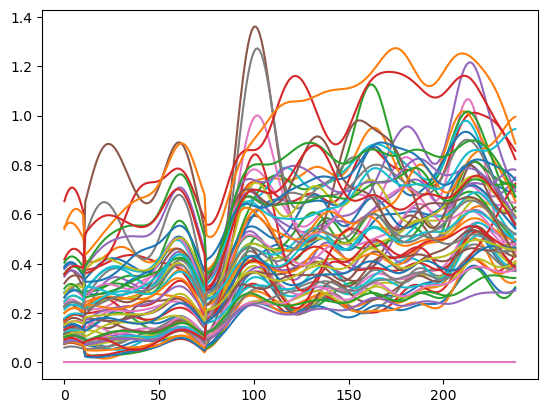

In [10]:
for ch in channels:
    plt.plot(df.xs("subject 1").xs("block 0").xs("target 1")[ch])

In [11]:
def index_to_color(index_list):
    numbers = np.array([int(el.split(" ")[-1]) for el in index_list])
    return numbers / numbers.max()

def map_to_range(output_range, array):
    min = array.min()
    max = array.max()
    return output_range[0] + ((array - min)*(output_range[1]-output_range[0])) / (max - min)

In [12]:
# https://pair-code.github.io/understanding-umap/
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
subject_name = "subject 37"
reducer = umap.UMAP(n_components=2,n_neighbors=100,min_dist=0.0)
embedding = reducer.fit_transform(df.xs(subject_name))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
embedding_df = pd.DataFrame(embedding)
del embedding

<Axes: xlabel='0', ylabel='1'>

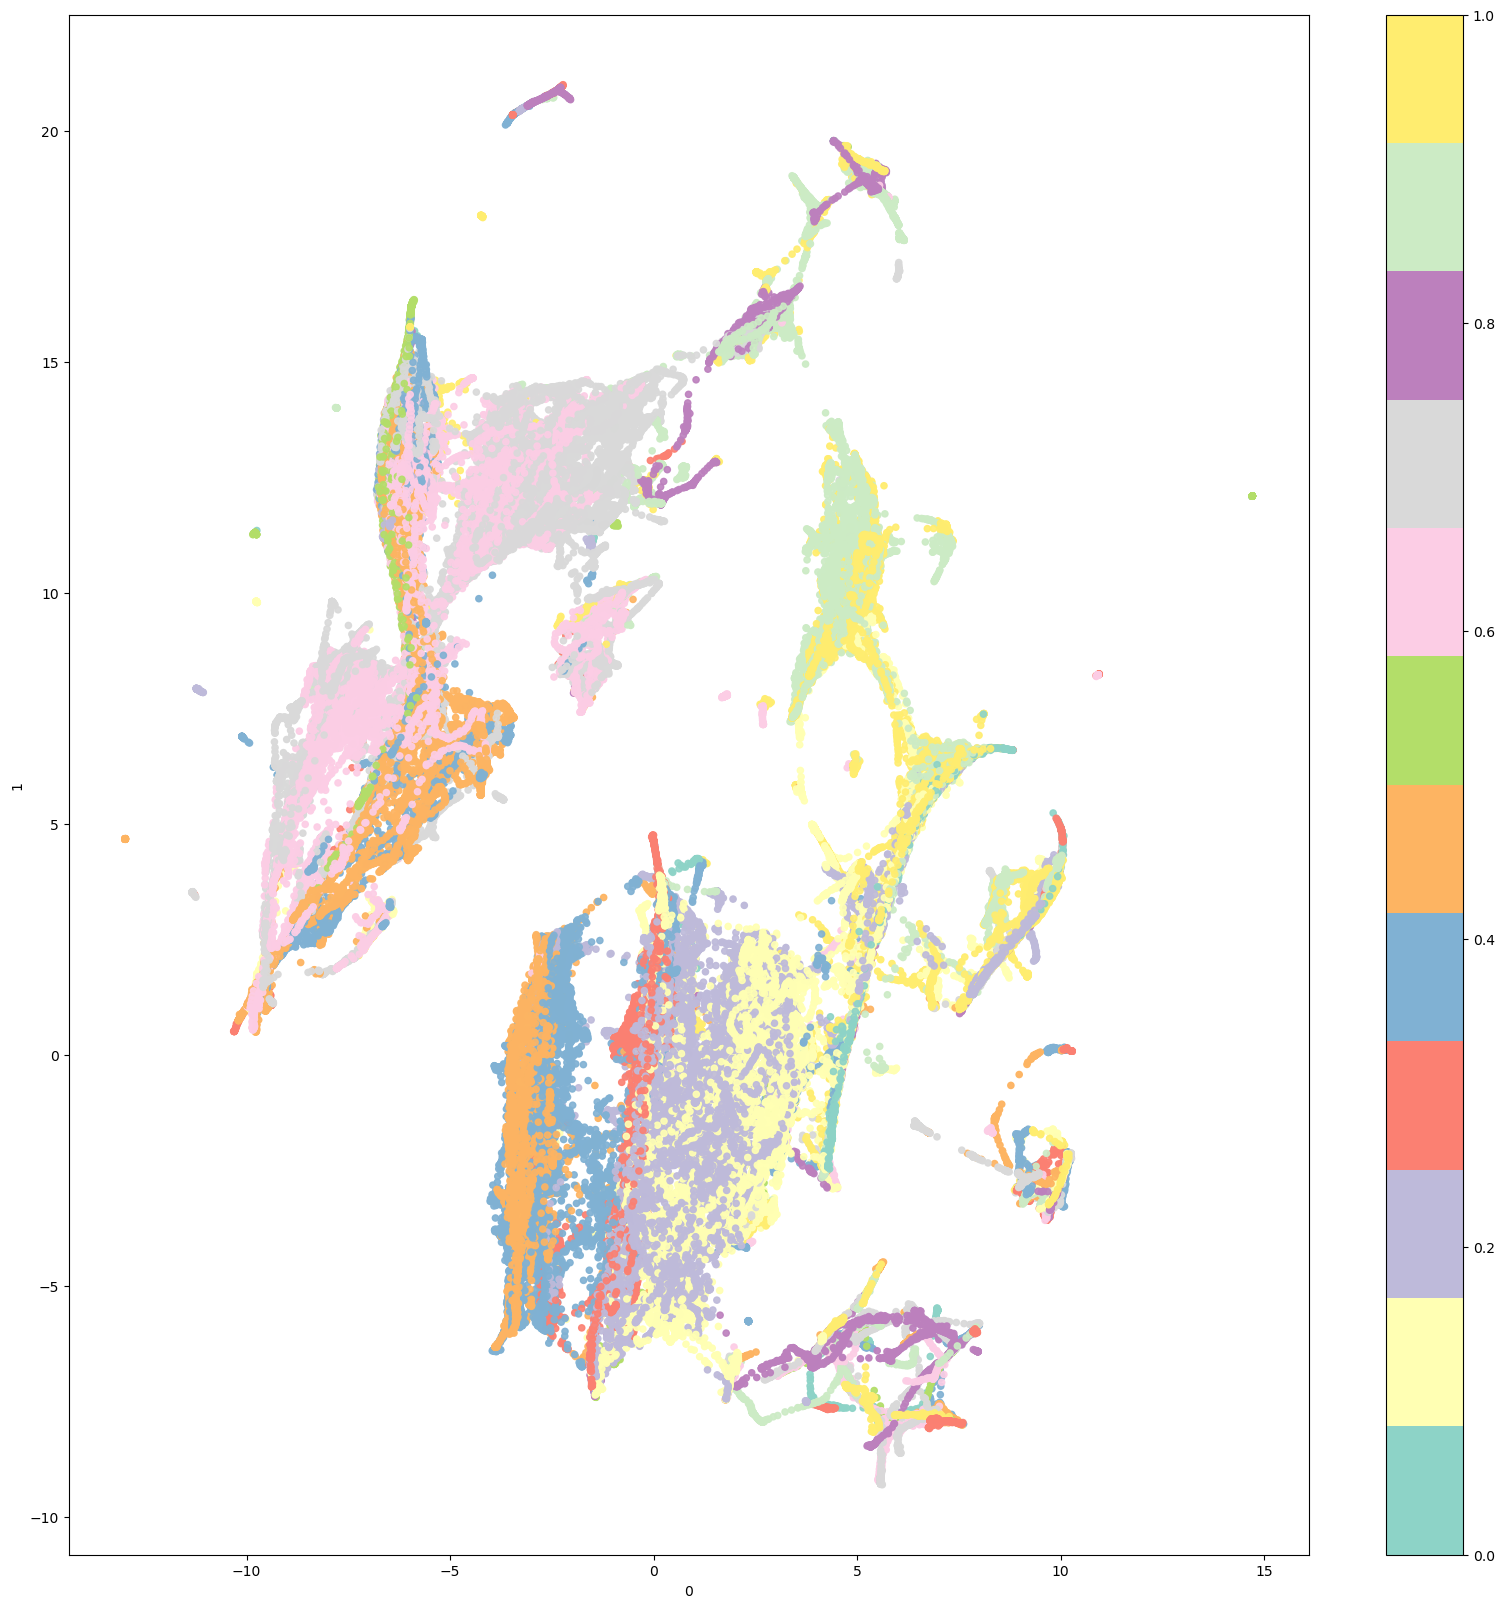

In [14]:
# block is color
# alpha is time
block_names = df.xs(subject_name).index.get_level_values("block").tolist()
target_names = df.xs(subject_name).index.get_level_values("target").tolist()
time_indices = np.array(df.xs(subject_name).index.get_level_values("time").tolist())
embedding_df.plot(kind="scatter",x=0,y=1,c=index_to_color(target_names),colormap="Set3",figsize=(20,20),alpha=map_to_range([0.9,1.0],time_indices))

<Axes: xlabel='0', ylabel='1'>

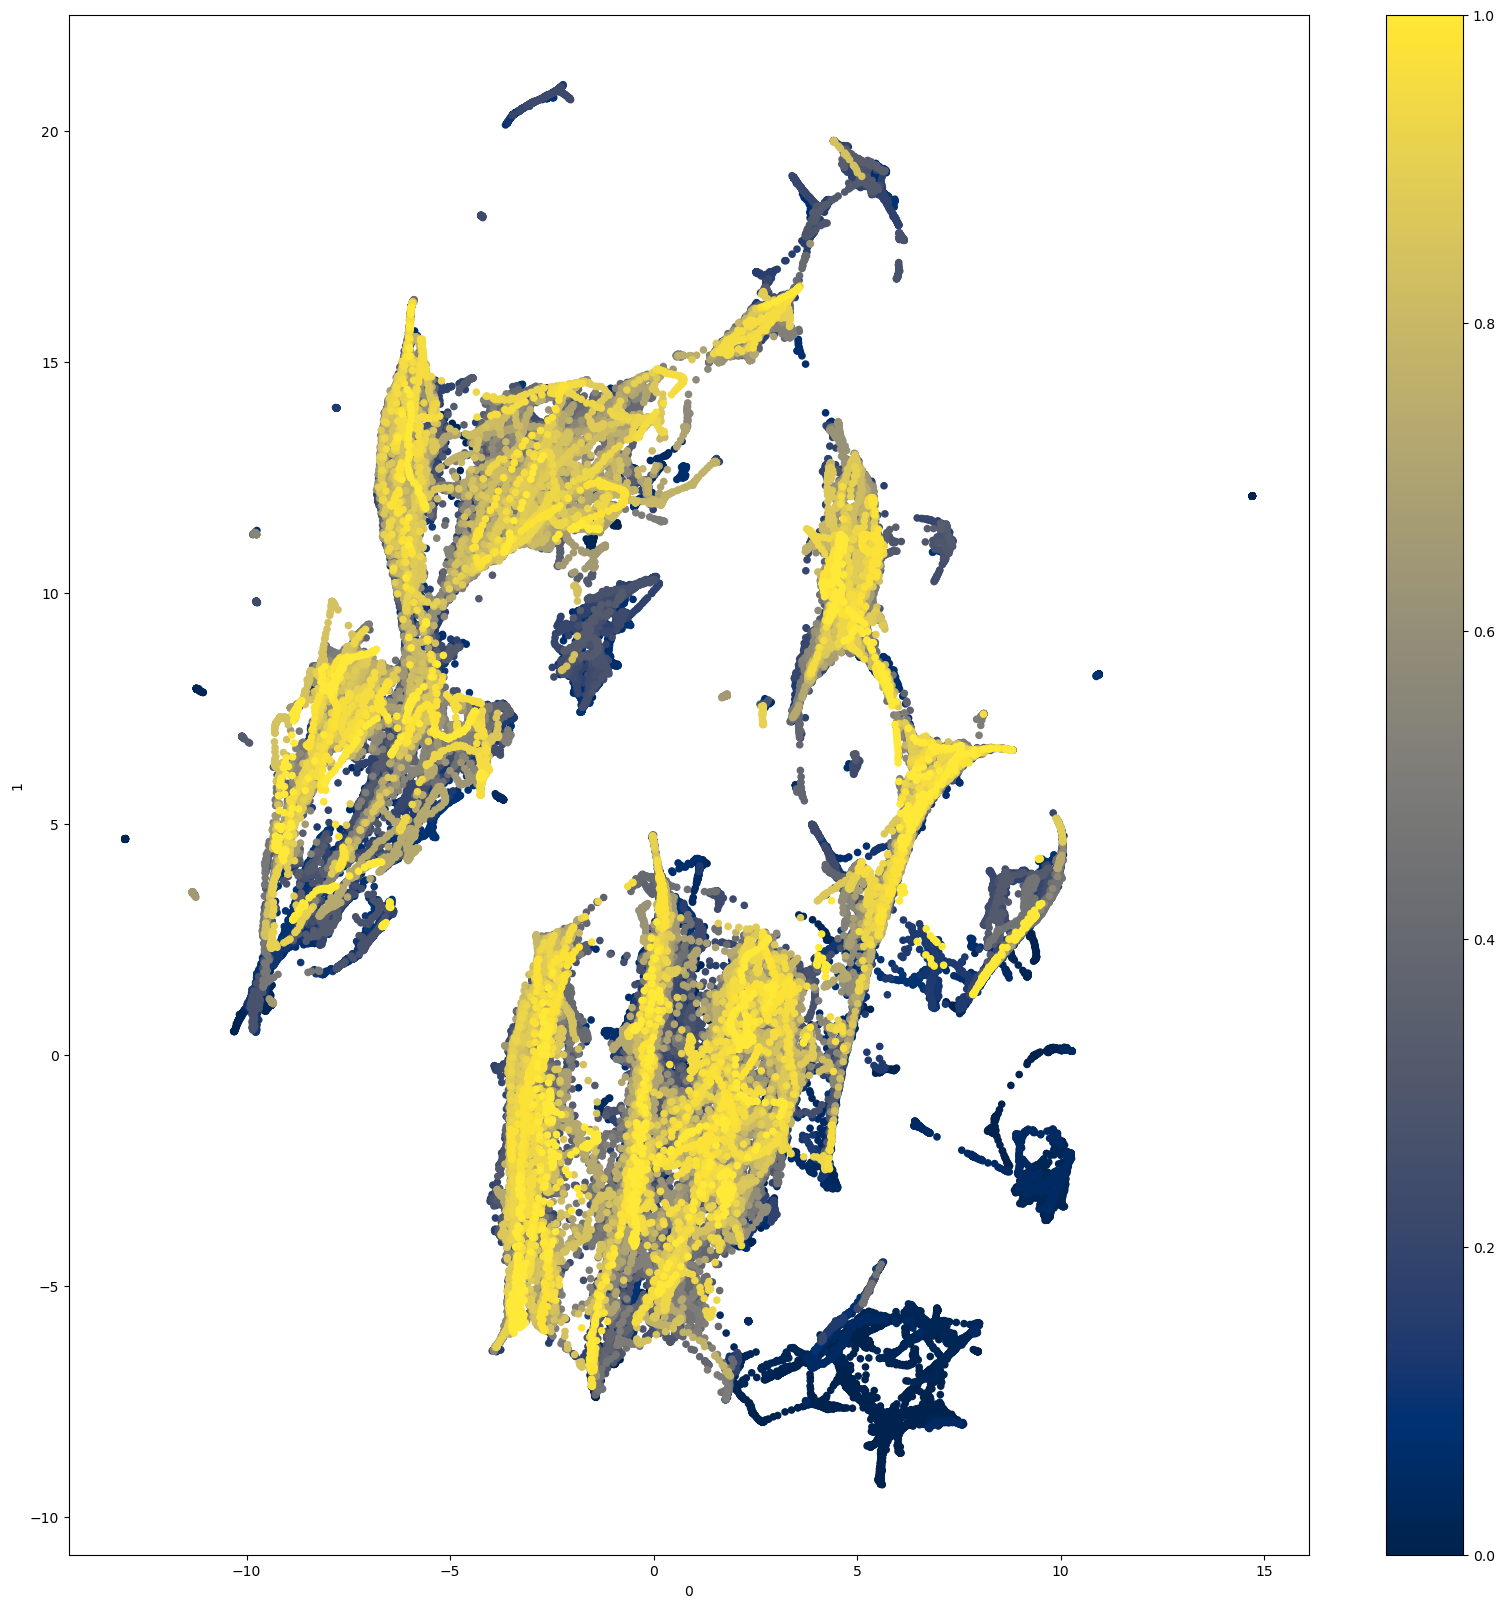

In [15]:
embedding_df.plot(kind="scatter",x=0,y=1,c=index_to_color(block_names),colormap="cividis",figsize=(20,20))

In [32]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=200)
clusterer.fit(embedding_df)
print("num clusters: ", clusterer.labels_.max())

num clusters:  30


In [33]:
df.xs(subject_name)["label"] = clusterer.labels_[:]

<Axes: xlabel='0', ylabel='1'>

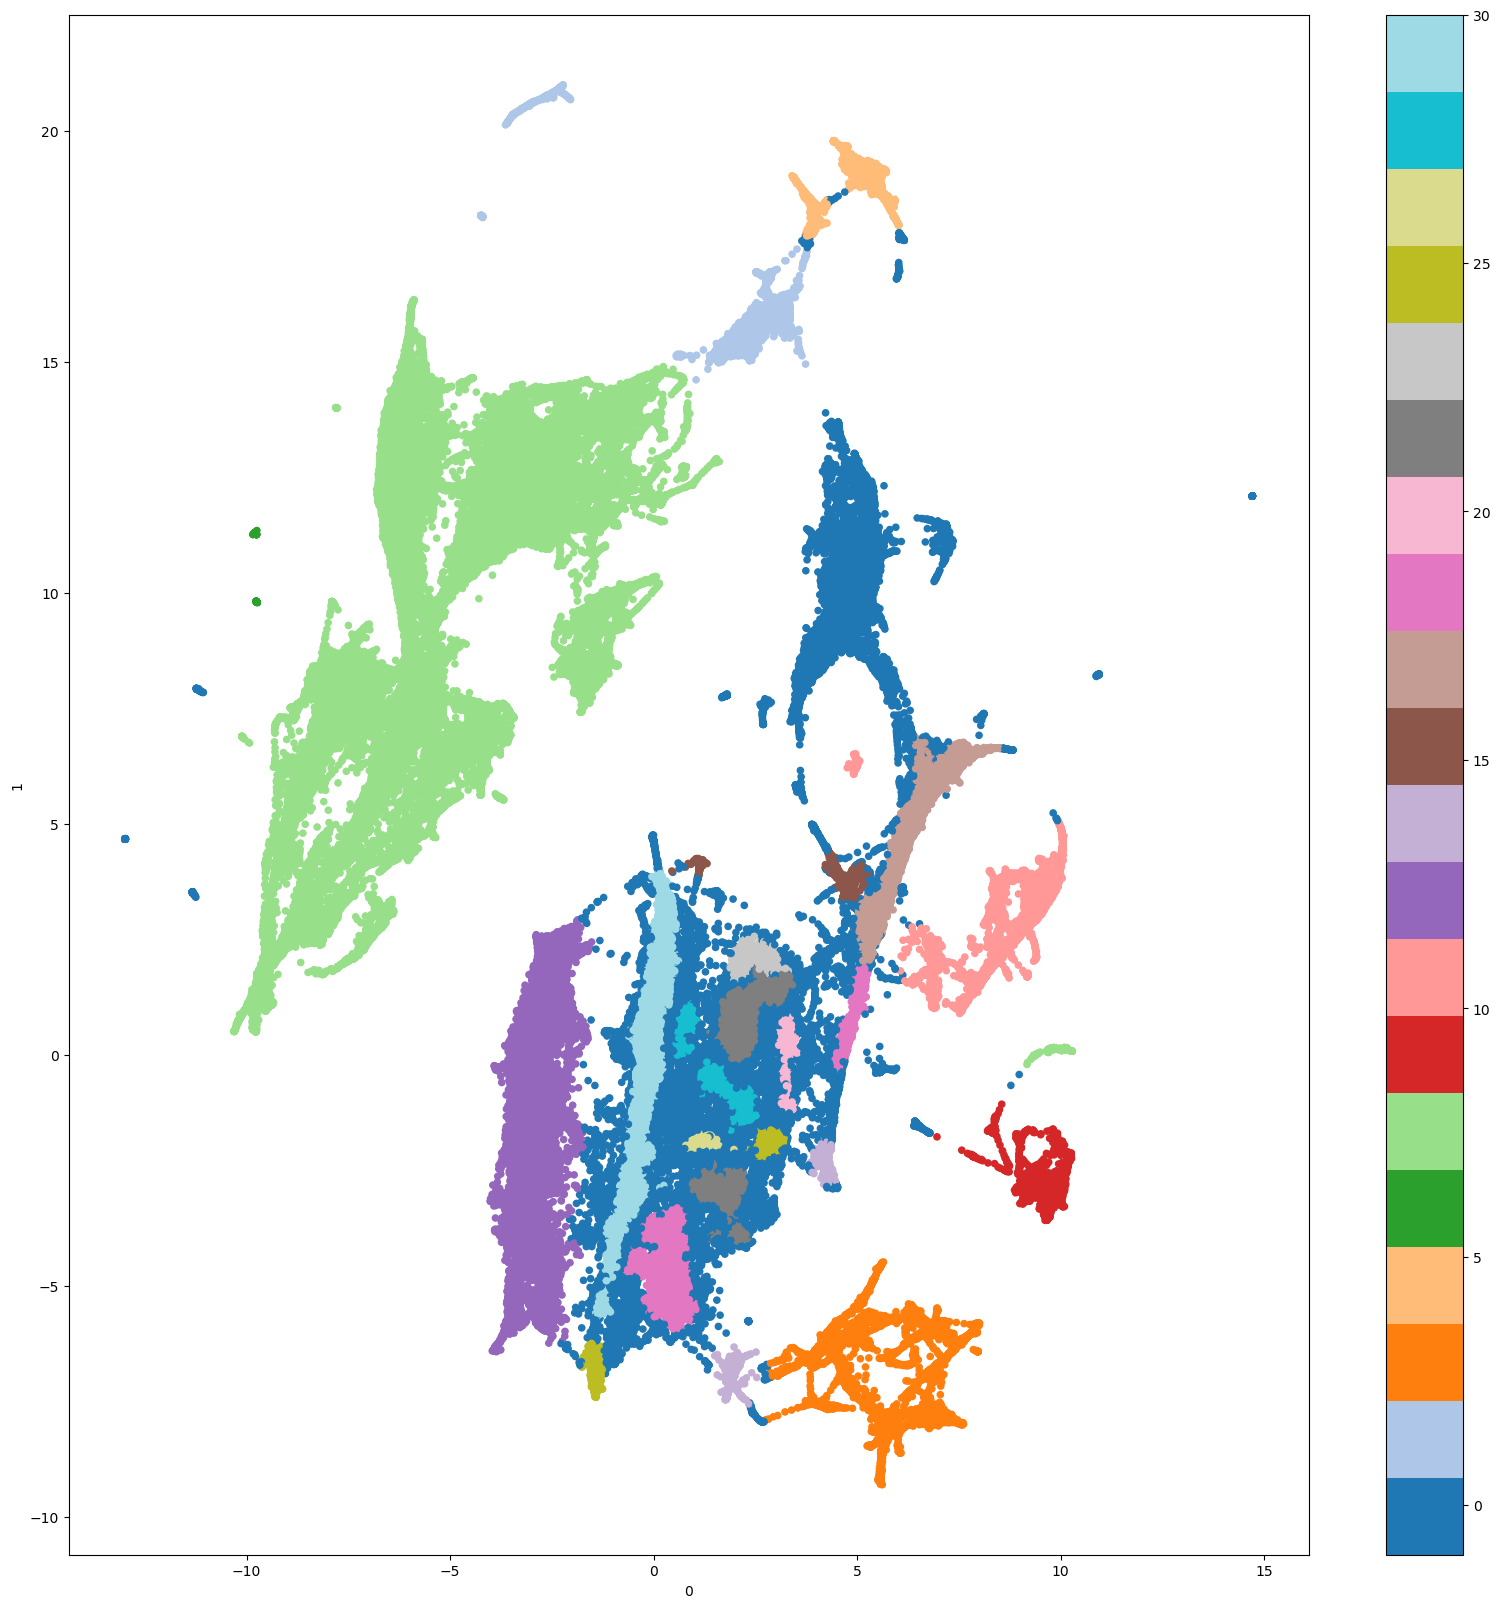

In [34]:
embedding_df.plot(kind="scatter",x=0,y=1,c=clusterer.labels_,colormap="tab20",figsize=(20,20))

In [ ]:
rewards = df["rewards"]
embedding_df.plot(kind="scatter",x=0,y=1,c=map_to_range([0.,1.0],rewards),colormap="viridis",figsize=(20,20))

## Notes 

- Time seems to "compress" the data, becoming more similar (closer on the manifold) over time?
- Time encompasses more clusters, so more information than just time
- Targets aren't well separated into clusters, so what are the clusters?
- What correlates with cluster labels?
    - Signal mean, covariance
    - Reward 